In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

Using TensorFlow backend.


In [2]:
from os import listdir
from os.path import isfile, join
mypath= 'training-synthetic/'
files = [join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f))]


In [3]:
import re
import numpy

def read_pgm(filename, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.

    Format specification: http://netpbm.sourceforge.net/doc/pgm.html

    """
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return numpy.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))


In [4]:
face=[]
import math
for file in files:     
    f=read_pgm(file)
    face.append(f)
    
face =np.asarray(face)
num_face = face.shape[0]
num_train = math.ceil(num_face *0.9)
#num_train = 180
img_rows = face.shape[1]
img_cols = face.shape[2]
ff= face

In [5]:
face.shape

(3240, 200, 200)

In [6]:
# split data into train / validation folds
np.random.seed(42)
n_pixels = img_rows * img_cols
x_train = ff[:num_train]
x_test = ff[num_train:num_face]

In [7]:
x_train.shape


(2916, 200, 200)

In [8]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), n_pixels))
x_test = x_test.reshape((len(x_test), n_pixels))

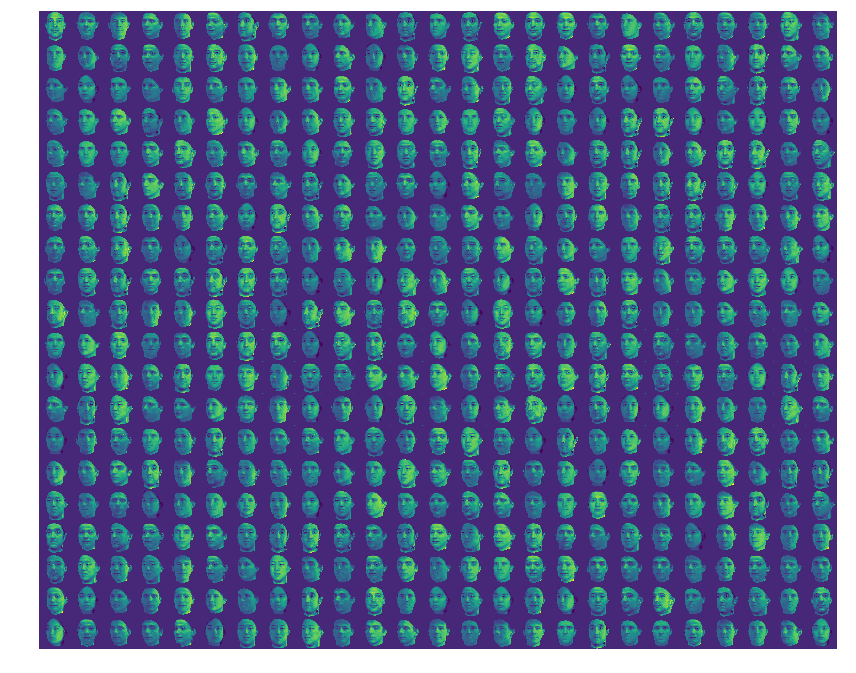

In [9]:
def show_examples(data, n=None, n_cols=20, thumbnail_cb=None):
    if n is None:
        n = len(data)    
    n_rows = int(np.ceil(n / float(n_cols)))
    figure = np.zeros((img_rows * n_rows, img_cols * n_cols))
    for k, x in enumerate(data[:n]):
        r = k // n_cols
        c = k % n_cols
        figure[r * img_rows: (r + 1) * img_rows,
               c * img_cols: (c + 1) * img_cols] = x
        if thumbnail_cb is not None:
            thumbnail_cb(locals())
        
    plt.figure(figsize=(12, 10))
    plt.imshow(figure)
    plt.axis("off")
    plt.tight_layout()
show_examples(ff, n=500, n_cols=25)

In [10]:
import tensorflow as tf
sess = tf.Session()

K.set_session(sess)

In [11]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)

    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon
#     return z_mean + K.exp(0.5 ) * epsilon

In [12]:
def plot_results(models,
                 latent_dim,
                 latent_num,
                 z_m_m, 
                 batch_size=128,
                 model_name="vae_face"):
    """Plots labels and MNIST digits as function of 2-dim latent vector

    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    #x_test = data
    latent_dim = latent_dim
    os.makedirs(model_name, exist_ok=True)

    
    
    """filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()
    """

    #filename = os.path.join(model_name, "face_over_latent.png")
    n = 20
    digit_size = 200
    img_rows, img_cols = 200, 200
    figure = np.zeros((img_rows , img_cols * n))
    grid_x = np.linspace(-5, 5, n)
    #grid_y = np.linspace(-5, 5, n)[::-1]
    z_sample = np.zeros((1,latent_dim))
    z_sample[0,:] = z_m_m 
    
    for j, xi in enumerate(grid_x):
        z_sample[0,latent_num] = z_m_m[latent_num] + xi
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(img_rows, img_cols)
        figure[0: img_rows,j * img_cols: (j + 1) * img_cols] = digit

    plt.figure(figsize=(20, 20))
    #start_range = digit_size // 2
    #end_range = n * digit_size + start_range + 1
    #pixel_range = np.arange(start_range, end_range, digit_size)
    #sample_range_x = np.round(grid_x, 1)
    #sample_range_y = np.round(grid_y, 1)
    #plt.xticks(pixel_range, sample_range_x)
    #plt.yticks(pixel_range, sample_range_y)
    #plt.xlabel("z[0]")
    #plt.ylabel("z[1]")
    plt.axis('off')
    plt.imshow(figure, cmap='gray')
    #plt.savefig(filename)
    plt.show()

In [13]:
# network parameters
original_dim = n_pixels
input_shape = (original_dim, )
intermediate_dim1 = 10000
intermediate_dim2 = 2000
intermediate_dim3 = 500

batch_size = 128
latent_dim = 4
epochs = 100

In [14]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x1 = Dense(intermediate_dim1, activation='relu')(inputs)
x2 = Dense(intermediate_dim2, activation='relu')(x1)
x3 = Dense(intermediate_dim3, activation='relu')(x2)

z_mean = Dense(latent_dim, name='z_mean')(x3)
z_log_var = Dense(latent_dim, name='z_log_var')(x3)


In [15]:
# standardize the mean of z, so that mean(m_z)=0 and cov(m_z)=I
def standardize(z_mean):
    z_m_m = K.mean(z_mean,axis=0, keepdims=True)
    z1 = z_mean - z_m_m
    n = tf.cast(K.shape(z_mean)[0], tf.float32)
    cov = K.transpose(z1) @ z1 /n
    
    D = tf.diag(tf.diag_part(cov)) ** 0.5
    
    L = tf.linalg.inv(tf.transpose(tf.cholesky(cov)))
       
#     z2 = z1 @ L @ D +  z_m_m
    z2 = z1 @ L  +  z_m_m

    return( z2)

In [16]:
# z_mean_std = Lambda(standardize, output_shape=(latent_dim,), name='z_mean_std')(z_mean)

In [17]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 40000)        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 10000)        400010000   encoder_input[0][0]              
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2000)         20002000    dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 500)          1000500     dense_2[0][0]                    
__________________________________________________________________________________________________
z_mean (De

In [18]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z')

x3 = Dense(intermediate_dim3, activation='relu')(latent_inputs)
x2 = Dense(intermediate_dim2, activation='relu')(x3)
x1 = Dense(intermediate_dim1, activation='relu')(x2)

# x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x1)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z (InputLayer)               (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               2500      
_________________________________________________________________
dense_5 (Dense)              (None, 2000)              1002000   
_________________________________________________________________
dense_6 (Dense)              (None, 10000)             20010000  
_________________________________________________________________
dense_7 (Dense)              (None, 40000)             400040000 
Total params: 421,054,500
Trainable params: 421,054,500
Non-trainable params: 0
_________________________________________________________________


In [19]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [20]:
models = (encoder, decoder)
data = (x_test )

# VAE loss = mse_loss or xent_loss + kl_loss

#     reconstruction_loss = mse(inputs, outputs)
reconstruction_loss = binary_crossentropy(inputs,
                                              outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 40000)             0         
_________________________________________________________________
encoder (Model)              [(None, 4), (None, 4), (N 421016508 
_________________________________________________________________
decoder (Model)              (None, 40000)             421054500 
Total params: 842,071,008
Trainable params: 842,071,008
Non-trainable params: 0
_________________________________________________________________


In [21]:
epochs = int(1E2)

In [22]:
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 2916 samples, validate on 324 samples
Epoch 1/10000


ResourceExhaustedError: OOM when allocating tensor with shape[10000,40000] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node training/Adam/Variable_16/Assign (defined at /home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:402)  = Assign[T=DT_FLOAT, _grappler_relax_allocator_constraints=true, use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/Adam/Variable_16, training/Adam/zeros_16)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'training/Adam/Variable_16/Assign', defined at:
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-411780f992c2>", line 4, in <module>
    validation_data=(x_test, None))
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/keras/engine/training.py", line 1010, in fit
    self._make_train_function()
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/keras/engine/training.py", line 509, in _make_train_function
    loss=self.total_loss)
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/keras/optimizers.py", line 487, in get_updates
    ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/keras/optimizers.py", line 487, in <listcomp>
    ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 704, in zeros
    return variable(v, dtype=dtype, name=name)
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 402, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 183, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 146, in _variable_v1_call
    aggregation=aggregation)
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 125, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2444, in default_variable_creator
    expected_shape=expected_shape, import_scope=import_scope)
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 187, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 1329, in __init__
    constraint=constraint)
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 1481, in _init_from_args
    validate_shape=validate_shape).op
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorflow/python/ops/state_ops.py", line 221, in assign
    validate_shape=validate_shape)
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorflow/python/ops/gen_state_ops.py", line 61, in assign
    use_locking=use_locking, name=name)
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[10000,40000] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node training/Adam/Variable_16/Assign (defined at /home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:402)  = Assign[T=DT_FLOAT, _grappler_relax_allocator_constraints=true, use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/Adam/Variable_16, training/Adam/zeros_16)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [18]:
z_output = sess.run( z_mean, feed_dict={'encoder_input: 0':x_train})

In [19]:
z_m_m = np.mean(z_output,axis=0)
z_m_m

array([-0.10893992, -0.03732264, -0.1513144 ,  0.06817105], dtype=float32)

Plot the Pearson correlation among Z

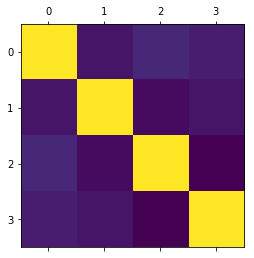

In [20]:
plt.matshow(np.corrcoef(z_output.T))

In [21]:
z_m_m

array([-0.10893992, -0.03732264, -0.1513144 ,  0.06817105], dtype=float32)

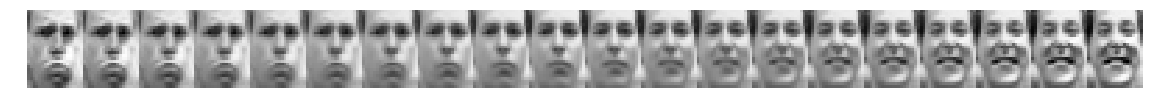

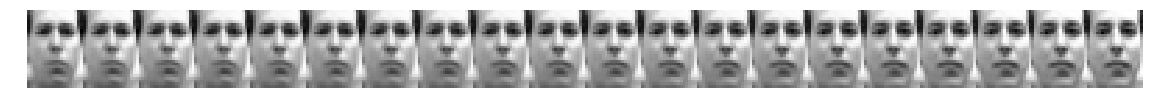

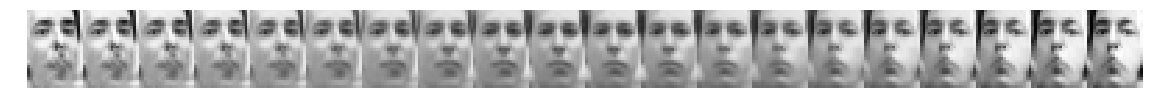

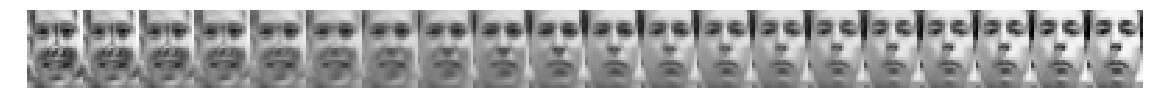

In [22]:
for i in range(0, latent_dim):
    plot_results(models,
                 latent_dim,
                 latent_num = i,
                 z_m_m = z_m_m ,
                 batch_size=batch_size,
                 model_name="vae_mlp")